<a href="https://colab.research.google.com/github/rk119/F20BC/blob/main/F20BC_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [231]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Load the data

In [3]:
df = x_train_all = pd.read_csv("/content/drive/MyDrive/F20BC-Dataset/data_banknote_authentication.csv")

### View the first 5 instances of the data

In [4]:
df.head()

,"3.6216,8.6661,-2.8073,-0.44699,0"
0,"4.5459,8.1674,-2.4586,-1.4621,0"
1,"3.866,-2.6383,1.9242,0.10645,0"
2,"3.4566,9.5228,-4.0112,-3.5944,0"
3,"0.32924,-4.4552,4.5718,-0.9888,0"
4,"4.3684,9.6718,-3.9606,-3.1625,0"


In [5]:
df.shape

(1371, 1)

In [6]:
if len(df.columns) == 1:
    # Split the single column into multiple columns by the comma delimiter
    df = df.iloc[:, 0].str.split(',', expand=True)

# Convert the split columns to numeric types
df = df.apply(pd.to_numeric)

# Check if there are 5 columns
if df.shape[1] == 5:
    # Split into features (X) and label (Y)
    X = df.iloc[:, :-1]
    Y = df.iloc[:, -1]

# Convert X and Y to numpy arrays
X_array = X.to_numpy()
Y_array = Y.to_numpy()

In [7]:
df

,0,1,2,3,4
0,4.54590,8.16740,-2.4586,-1.46210,0
1,3.86600,-2.63830,1.9242,0.10645,0
2,3.45660,9.52280,-4.0112,-3.59440,0
3,0.32924,-4.45520,4.5718,-0.98880,0
4,4.36840,9.67180,-3.9606,-3.16250,0
...,...,...,...,...,...
1366,0.40614,1.34920,-1.4501,-0.55949,1
1367,-1.38870,-4.87730,6.4774,0.34179,1
1368,-3.75030,-13.45860,17.5932,-2.77710,1
1369,-3.56370,-8.38270,12.3930,-1.28230,1


In [8]:
len(X_array)

1371

In [9]:
len(Y_array)

1371

# Functions

### Activation Functions

In [10]:
class ActivationFunctions:
  def evaluate(self,x):
    pass
  def derivate(self,x):
    pass

class Identity:
  def evaluate(self,x):
    return x
  def derivative(self,x):
    return 1

class Sigmoid(ActivationFunctions):
  def evaluate(self,x):
    return 1 / (1 + np.exp(-x))
  def derivative(self,x):
    f = self.evaluate(x)
    return f * (1-f)

class Tanh(ActivationFunctions):
  def evaluate(self,x):
    return np.tanh(x)
  def derivative(self,x):
    f = self.evaluate(x)
    return 1 - f ** 2

class relu(ActivationFunctions):
  def evaluate(self,x):
    return np.maximum(0, x)
  def derivative(self,x):
    return (x > 0).astype(float)

### Loss Functions

In [11]:
class LossFunctions:
  def evaluate(self,x):
    pass
  def derivate(self,x):
    pass

# y is predictions made by the neural network
# t is target/actual numbers corresponding to inputs
class Mse(LossFunctions):
  def evaluate(self, y, t):
    return ((t - y) ** 2).mean()
  def derivative(self, y, t):
    return 2 * (y - t) / len(y)

class BinaryCrossEntropy(LossFunctions):
  def evaluate(self, y, t):
    y_pred = np.clip(y, 1e-7, 1 - 1e-7)
    term0 = (1 - t) * np.log(1 - y_pred + 1e-7)
    term1 = t * np.log(y_pred + 1e-7)
    return - (term0 + term1).mean()

  def derivative(self, y, t):
    y_pred = np.clip(y, 1e-7, 1 - 1e-7)
    return (t / y_pred) - (1 - t) / (1 - y_pred)

class Hinge(LossFunctions):
  def evaluate(self, y, t):
    return np.maximum(0, 1 - t * y).mean()

  def derivative(self, y, t):
    return np.where(t * y < 1, -t, 0)

In [12]:
# Define test cases
test_cases = [
    {"y": np.array([1,2,3,4,5]), "t": np.array([1,2,3,5,5]), "expected": 0.2},
    {"y": np.array([1, 2, 3]), "t": np.array([2, 3, 4]), "expected": 1.0},
    # Add more test cases as needed
]

# Test function
def test_MSE_loss(loss_function, test_cases):
    for i, test_case in enumerate(test_cases, start=1):
        y, t = test_case["y"], test_case["t"]
        expected = test_case["expected"]
        result = loss_function.evaluate(y, t)
        assert np.isclose(result, expected), f"Test case {i} failed: expected {expected}, got {result}"
        print(f"Test case {i} passed.")

test_MSE_loss(Mse(), test_cases)

Test case 1 passed.
Test case 2 passed.


# Neural Network

In [14]:
class InputLayer:
    def __init__(self, input_size):
        self.nb_nodes = input_size

    def forward(self, input_data):
        return input_data

class Layer:
    def __init__(self, input_size, nodes, activation, weights=None, biases=None):
        self.nb_nodes = nodes
        self.X_in = None
        self.W = weights if weights is not None else np.random.randn(input_size, nodes)
        self.B = biases if biases is not None else np.random.randn(nodes)
        self.activation = activation
        # print(input_size, 'W = ', self.W, 'B = ', self.B)

    def forward(self, input_data):
        self.X_in = input_data
        z = np.dot(input_data, self.W) + self.B
        out = self.activation.evaluate(z)
        return out

class NeuralNetwork:
    def __init__(self, configuration, position=None):
        self.layers = []
        input_size = configuration[0]

        # The input layer is simply added as a pass-through layer
        self.layers.append(InputLayer(input_size))

        # If a position vector is provided, it contains weights and biases for each layer
        if position is not None:
            for idx, (nodes, activation) in enumerate(configuration[1:]):
                weights, biases = position[idx]
                layer = Layer(input_size, nodes, activation, weights=weights, biases=biases)
                self.add(layer)
                input_size = nodes  # Update input size for the next layer
        else:
            # If no position vector, initialize layers with random weights and biases
            for nodes, activation in configuration[1:]:
                layer = Layer(input_size, nodes, activation)
                self.add(layer)
                input_size = nodes  # Update input size for the next layer

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input_data):
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data

# PSO

In [232]:
class Particle:
    def __init__(self, neural_network_structure):
        self.position = self.initialize_position(neural_network_structure)
        self.velocity = self.initialize_velocity(neural_network_structure)
        self.best_position = self.position
        self.best_fitness = float('inf')
        self.current_fitness = float('inf')

    def initialize_position(self, structure):
        '''
        position is a list of tuples that contain the weights and biases of every layer, size: num_of_hidden_layers
        weights is a 2-d list of weights, size: num_of_input_nodes x num_of_nodes.
        biases is a list of biases, size: num_of_nodes.

        position = [
          (weights, biases)
          ...
          (weights, biases)
        ]
        '''
        position = []
        input_size = structure[0]  # Initial input size is the number of nodes in the input layer

        # Initialize weights and biases randomly
        for nodes, activation in structure[1:]:
            # Initialize weights and biases for this layer
            layer_weights = np.random.randn(input_size, nodes)
            layer_biases = np.random.randn(nodes)
            position.append((layer_weights, layer_biases))

            # Update input_size for the next layer
            input_size = nodes

        return position

    def initialize_velocity(self, structure):
        # Initialize velocities for weights and biases as zeros
        velocity = []
        input_size = structure[0]  # Start with the number of nodes in the input layer

        for nodes, activation in structure[1:]:
            # Initialize velocity for weights and biases for this layer
            layer_weights_velocity = np.zeros((input_size, nodes))
            layer_biases_velocity = np.zeros(nodes)
            velocity.append([layer_weights_velocity, layer_biases_velocity])

            # Update input_size for the next layer
            input_size = nodes

        return velocity

    def update_personal_best(self, fitness):
        if fitness < self.best_fitness:
            self.best_fitness = fitness
            self.best_position = self.position

    def update_velocity(self, global_best_position, alpha, beta, gamma, delta):
        flattened_best_global = np.concatenate([item.flatten() for sublist in global_best_position for item in sublist])
        flattened_best_personal = np.concatenate([item.flatten() for sublist in self.best_position for item in sublist])
        flattened_current = np.concatenate([item.flatten() for sublist in self.position for item in sublist])
        print(self.velocity)
        flattened_velocity = np.concatenate([item.flatten() for sublist in self.velocity for item in sublist])

        r1, r2, r3 = np.random.rand(3)
        cognitive_component = beta * r1 * (flattened_best_personal - flattened_current)
        social_component = gamma * r2 * (flattened_best_global - flattened_current)
        inertia = alpha * flattened_velocity
        self.velocity = inertia + cognitive_component + social_component

    def update_velocity(self, global_best_position, alpha, beta, gamma, delta):
        new_velocity = []

        # Iterate over corresponding elements of velocity, best_position, position, and global_best_position
        for v, p_best, p_current, g_best in zip(self.velocity, self.best_position, self.position, global_best_position):
            new_velocity_layer = []
            r1, r2 = np.random.rand(), np.random.rand()

            for v_layer, p_best_layer, p_current_layer, g_best_layer in zip(v, p_best, p_current, g_best):
                # Perform element-wise operations for weights and biases
                cognitive_component = beta * r1 * (p_best_layer - p_current_layer)
                social_component = gamma * r2 * (g_best_layer - p_current_layer)
                new_velocity_layer.append(alpha * v_layer + cognitive_component + social_component)

            new_velocity.append(tuple(new_velocity_layer))

        self.velocity = new_velocity

    def update_position(self, epsilon):
        new_position = []

        # Iterate over corresponding elements of position and velocity
        for p, v in zip(self.position, self.velocity):
            new_position_layer = []

            for p_layer, v_layer in zip(p, v):
                # Perform element-wise operations for weights and biases
                new_position_layer.append(p_layer + epsilon * v_layer)

            new_position.append(tuple(new_position_layer))

        self.position = new_position

In [ ]:
class ParticleSwarmOptimization:
    def __init__(self, neural_network_structure, num_particles, alpha, beta, gamma, delta, epsilon):
        self.swarm_size = num_particles
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
        self.particles = self.initialize(neural_network_structure)
        self.gBest_position = None
        self.gBest_fitness = float('inf')

    def initialize(self, structure):
        # Initialize a swarm of particles
        particles = [Particle(structure) for _ in range(self.swarm_size)]
        return particles

    def update_global_best(self, particle):
        if particle.best_fitness < self.gBest_fitness:
            self.gBest_fitness = particle.best_fitness
            self.gBest_position = particle.best_position

# Main Method

In [233]:
def evaluate_accuracy(neural_network, X_test, Y_test, output_activation):
    predictions = neural_network.forward(X_test)
    predictions = predictions.flatten()  # Ensure predictions are 1D
    # print(predictions)

    # Determine threshold based on the activation function
    if isinstance(output_activation, Sigmoid):
        threshold = 0.5
    elif isinstance(output_activation, (Tanh, relu)):
        threshold = 0.0
    else:
        raise ValueError("Unsupported activation function for output layer")

    # Apply threshold
    predicted_classes = (predictions >= threshold).astype(int) # Convert probabilities to class labels

    # Check if shapes and types match
    if predicted_classes.shape != Y_test.shape:
        raise ValueError(f"Shape mismatch: predicted {predicted_classes.shape}, actual {Y_test.shape}")

    if predicted_classes.dtype != Y_test.dtype:
        raise ValueError(f"Type mismatch: predicted {predicted_classes.dtype}, actual {Y_test.dtype}")

    # Calculate accuracy
    comparison = (predicted_classes == Y_test)
    correct_predictions = np.sum(comparison)

    if correct_predictions > len(Y_test):
        raise ValueError("More correct predictions than samples, check data and comparison logic.")

    accuracy = correct_predictions / len(Y_test)
    return accuracy

In [234]:
# def calculate_fitness(neural_network, X, Y, output_activation):
#     accuracy = evaluate_accuracy(neural_network, X, Y, output_activation)
#     # In this case, higher accuracy is better, so you can directly return it as fitness
#     return accuracy

def calculate_fitness(neural_network, X, Y, loss_function):
    predictions = neural_network.forward(X)
    # print(predictions[0])
    loss = loss_function.evaluate(predictions, Y)
    # print("Loss",loss)
    return loss


0.7237493533310521
0.7237493533310521
0.7237493533310521
0.7237493533310521
0.719078737082367
0.7168974978928467
0.7158695642231159
0.7153711701627429
0.7151257343012529
0.7150039577343256
0.7149433081229389
0.7145727596776122
0.7134003844336021
0.7126761567380197
0.7123217404363474
0.7119465571457657
0.7110122820777529
0.7104657203417396
0.7101645624745048
0.7088309892595909
0.7081828937440413
0.7078676388123437
0.7077122131924628
0.7076350374362331
0.707596584424694
0.7075773929445781
0.7075678059688567
0.7075630146718722
0.707386334534579
0.706405793454864
0.7058104055448076
0.7041597559392928
0.7033552860772683
0.702490545333006
0.7019651675165755
0.7011464940114188
0.7006740230546719
0.7004435479963119
0.7003297913077744
0.7002733274888389
0.7002452248573287
0.7002035878039184
0.6992273864974385
0.6987676912576042
0.698551030104505
0.6984459667743799
0.6983940143269429
0.6983681558421164
0.6983552697775939
0.698348839829664
0.6983456260248242
0.698344020620717
0.6983432183813996
0

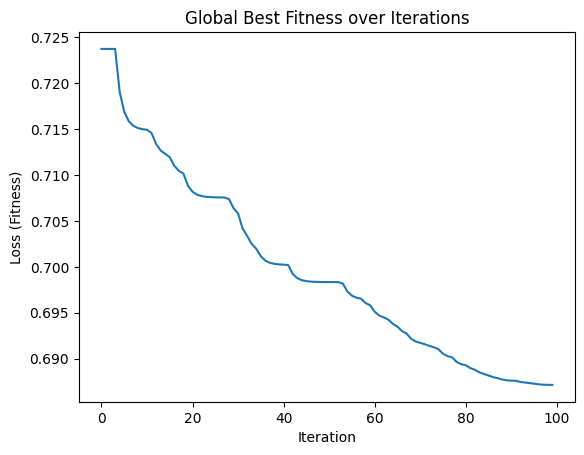

In [246]:
def main():
    relu_activation = relu()
    sigmoid_activation = Sigmoid()
    tanh_activation = Tanh()

    # Sample input (1 sample, 4 features)
    # input_data = np.array([[1.0, 2.0, 3.0, 4.0],[5.0, 6.0, 3.0, 7.0],[5.0, 6.0, 3.0, 7.0]])
    input_data = X_array

    # Pick number of input nodes between 1 and num of features
    num_features = input_data.shape[1]  # number of features
    input_size = 3  # User chosen number

    # User selected features to keep # number of selected_features should be equal to input_size
    selected_features = [0, 2, 3]
    # Only keep the user selected features in the input data
    input_data = input_data[:, selected_features]

    # Train:Test Split
    test_size = 0.2  # User defined split ratio
    X_train, X_test, Y_train, Y_test = train_test_split(input_data, Y_array, test_size=test_size, random_state=42)

    # Configuration: [input_size, [nodes, activation], [nodes, activation], ...]
    configuration = [
        input_size,  # User chosen input size
        [4, sigmoid_activation], # First hidden layer
        [5, relu_activation],  # Second hidden layer
        [1, sigmoid_activation]  # Output layer
    ]

    # PSO Parameters
    num_particles = 20
    alpha = 0.5  # inertia weight
    beta = 0.8  # cognitive weight
    gamma = 0.5  # social weight
    delta = 0.9  # global weight
    epsilon = 0.02  # position update step size
    num_iterations = 100
    loss_function = BinaryCrossEntropy() # used to calculate fitness # binaryCrossEntropy is best for binary classification

    # Initialize PSO
    pso = ParticleSwarmOptimization(configuration, num_particles, alpha, beta, gamma, delta, epsilon)

    # Initialize neural networks for each particle with their initial positions
    neural_networks = [NeuralNetwork(configuration, position=particle.position) for particle in pso.particles]

    # Extract the activation function of the output layer from the configuration
    output_activation = configuration[-1][1]  # last tuple in the configuration list is for the output layer

    global_best_fitness_history = []  # List to track the global best fitness to plot loss function

    for iteration in range(num_iterations):
        # Calculate fitness and update personal best
        for i, particle in enumerate(pso.particles):
            neural_networks[i] = NeuralNetwork(configuration, position=particle.position)
            # calculate fitness
            fitness = calculate_fitness(neural_networks[i], X_train, Y_train, loss_function)
            # Update personal best
            particle.update_personal_best(fitness)
            # Update global best
            pso.update_global_best(particle)

        # Update velocity and position
        for particle in pso.particles:
            # print("Best Position i.e., Neural Network:\n",pso.gBest_position)
            # print("Weigths & Biases of layer 1:\n",(pso.gBest_position[0]))
            # print("Weights",pso.gBest_position[0][0])
            # print("Weights from 1st node in input layer to first hidden layers nodes:\n",pso.gBest_position[0][0][0])
            # print("Biases",pso.gBest_position[0][1])

            # print(particle.velocity)
            particle.update_velocity(pso.gBest_position, alpha, beta, gamma, delta)
            # print(particle.velocity)

            # print("bfr",particle.position)
            particle.update_position(epsilon)
            # print("aft",particle.position)

        print(pso.gBest_fitness)

        # Update global best fitness history
        global_best_fitness_history.append(pso.gBest_fitness)

    best_nn = NeuralNetwork(configuration, position=pso.gBest_position)
    best_accuracy = evaluate_accuracy(best_nn, X_train, Y_train, output_activation)
    print("best_accuracy",best_accuracy)

    # Plotting the global best fitness history
    plt.plot(global_best_fitness_history)
    plt.title('Global Best Fitness over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Fitness)')
    plt.show()

if __name__ == "__main__":
    main()

# IGNORE

### Layer Initialization

In [ ]:
# class InputLayer:
#     def __init__(self, input_size):
#         self.nb_nodes = input_size

#     def forward(self, input_data):
#         return input_data

# class Layer:
#     def __init__(self, input_size, nodes, activation):
#         self.nb_nodes = nodes
#         self.X_in = None
#         self.W = np.random.randn(input_size, nodes)
#         self.B = np.random.randn(nodes)
#         self.activation = activation
#         # print(input_size, 'W = ', self.W, 'B = ', self.B)

#     def forward(self, input_data):
#         self.X_in = input_data
#         z = np.dot(input_data, self.W) + self.B
#         out = self.activation.evaluate(z)
#         return out

### Neural Network

In [ ]:
# class NeuralNetwork:
#     def __init__(self, configuration):
#         self.layers = []
#         input_size = configuration[0]
#         self.layers.append(InputLayer(input_size))
#         for layer_config in configuration[1:]:
#             nodes, activation = layer_config
#             layer = Layer(self.layers[-1].nb_nodes, nodes, activation)
#             self.add(layer)

#     def add(self, layer):
#         self.layers.append(layer)

#     def forward(self, input_data):
#         for layer in self.layers:
#             input_data = layer.forward(input_data)
#         return input_data

### Main Method

In [ ]:
# def main():
#     relu_activation = relu()
#     sigmoid_activation = Sigmoid()

#     # Sample input (1 sample, 4 features)
#     input_data = np.array([[1.0, 2.0, 3.0, 4.0],[5.0, 6.0, 3.0, 7.0],[5.0, 6.0, 3.0, 7.0]])

#     # Configuration: [input_size, [nodes, activation], [nodes, activation], ...]
#     configuration = [
#         4,  # Input size
#         [4, relu_activation],  # First hidden layer
#         [5, relu_activation],  # Second hidden layer
#         [3, sigmoid_activation]  # Output layer
#     ]


#     # Initialize Neural Network with the layer configurations
#     nn = NeuralNetwork(configuration)

#     # Perform feedforward operation
#     output = nn.forward(input_data)

#     # output is an array of feedforward being done on all samples
#     print("Output of the last layer:", output)

# if __name__ == "__main__":
#     main()

Output of the last layer: [[1.26509562e-02 1.75881331e-02 9.88595956e-01]
 [5.40614896e-06 9.99936526e-01 9.66071586e-01]
 [5.40614896e-06 9.99936526e-01 9.66071586e-01]]


### Fitness Functions

In [13]:
# class FitnessFunctions:
#     def evaluate(self, x):
#         pass

# class Sphere(FitnessFunctions):
#     def evaluate(self, x):
#         return np.sum(x**2)

# class Rastrigin(FitnessFunctions):
#     def evaluate(self, x):
#         A = 10 # constant that determines the amplitude of the cosine components
#         return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# class Schwefel(FitnessFunctions):
#     def evaluate(self, x):
#         return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))